## 20-1학기 시스템 경영 종합 설계
# 5조 인공 신경망을 이용한 병원 폐업 예측 모델링  

# - 목차 -
- 연구 목적
- 데이터 로드
- 데이터 전처리
- 모델링 및 학습
- 예측 및 평가

# 연구 목적

대출 상품의 심사 과정에서, 병원의 상환 기간 내 폐업 가능성을 예측해 대출 승인/반려 여부를 결정한다. 또한, 리스크에 따라 우대이율을 책정하기 위해 병원의 폐업 여부를 예측한다.

In [1]:
import pandas as pd
import numpy as np

train_data = pd.read_csv('./data/train.csv').reset_index()
test_data = pd.read_csv('./data/test.csv').reset_index()

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 59 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               301 non-null    int64  
 1   inst_id             301 non-null    int64  
 2   OC                  301 non-null    object 
 3   sido                301 non-null    object 
 4   sgg                 301 non-null    int64  
 5   openDate            301 non-null    int64  
 6   bedCount            296 non-null    float64
 7   instkind            300 non-null    object 
 8   revenue1            293 non-null    float64
 9   salescost1          293 non-null    float64
 10  sga1                293 non-null    float64
 11  salary1             293 non-null    float64
 12  noi1                293 non-null    float64
 13  noe1                293 non-null    float64
 14  interest1           293 non-null    float64
 15  ctax1               293 non-null    float64
 16  profit1 

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import shap

# 데이터 전처리
## 

In [3]:
#Removing the comma in the employee1 and 2 columns in the test dataset and replace it with empty space and convert it to float format.
test_data.employee1 = test_data.employee1.astype('str').str.replace(",", "").astype('float')
test_data.employee2 = test_data.employee2.astype('str').str.replace(",", "").astype('float')

In [4]:
#Combining the train and test dataset
train_test_prod = train_data.append(test_data)

#Get the object and numeric columns seperately 
factor_columns = train_test_prod.select_dtypes(include = ['object']).columns
numeric_columns = train_test_prod.columns.difference(factor_columns)

#After analysis realized that the bed counts of these two hospitals may have had wrong entries.
#Filling up the empty instkind and bedCount for hospital id 430 and 413
train_test_prod.loc[train_test_prod.inst_id == 430, ['instkind']] = 'dental_clinic'
train_test_prod.loc[train_test_prod.inst_id == 430, ['bedCount']] = 0
train_test_prod.loc[train_test_prod.inst_id == 413, ['bedCount']] = -999

#Fill the empty values in the object columns as "Not sure"
train_test_prod[factor_columns] = train_test_prod[factor_columns].fillna('Not_sure')

#Fill all the empty values in the numeric columns as -999
train_test_prod[numeric_columns] = train_test_prod[numeric_columns].fillna(-999)

In [5]:
#Convert all the object columns to numeric since the ML algorithms don't accept object features directly 
fac_le = LabelEncoder()
train_test_prod[factor_columns] = train_test_prod.loc[:,factor_columns].apply(lambda x : fac_le.fit_transform(x))

#Splitting back data to train prod and test prod
train_prod = train_test_prod.loc[train_test_prod.OC != 1,]
test_prod = train_test_prod.loc[train_test_prod.OC == 1,]

In [6]:
train_prod

,index,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,0,1,2,2,73,20071228.0,175.0,5,4.217530e+09,0.000000e+00,...,7.589937e+08,2.228769e+08,0.000000e+00,5.361169e+08,3.900000e+08,2.619290e+09,1.271224e+09,62.0,64.0,2
1,1,3,2,9,32,19970401.0,410.0,3,-9.990000e+02,-9.990000e+02,...,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,801.0,813.0,2
2,2,4,2,8,89,20161228.0,468.0,5,1.004522e+09,5.154837e+08,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,234.0,1.0,2
3,3,7,2,10,141,20000814.0,353.0,3,7.250734e+10,0.000000e+00,...,3.775501e+10,1.701860e+10,9.219427e+09,2.073641e+10,1.510000e+10,1.295427e+10,7.740829e+09,663.0,663.0,2
4,4,9,2,9,32,20050901.0,196.0,3,4.904354e+10,0.000000e+00,...,5.143259e+10,3.007259e+10,1.759375e+10,2.136001e+10,1.410803e+10,5.561941e+06,9.025550e+09,206.0,197.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,296,422,2,13,178,20050211.0,214.0,5,7.614697e+09,4.153475e+08,...,9.423771e+09,2.618201e+09,0.000000e+00,6.805570e+09,5.930000e+09,5.379502e+09,8.116416e+08,193.0,141.0,2
297,297,423,0,2,159,20140618.0,-999.0,4,6.717144e+09,8.200000e+09,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,79.0,79.0,2
298,298,426,0,7,107,19830705.0,-999.0,4,0.000000e+00,0.000000e+00,...,6.370097e+09,2.170973e+09,0.000000e+00,4.199124e+09,2.498749e+09,3.259161e+09,0.000000e+00,-999.0,-999.0,0
299,299,427,0,8,169,20070101.0,180.0,5,2.116892e+09,2.681748e+08,...,6.392336e+08,6.400000e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,100.0,-999.0,0


In [7]:
for i in range(len(train_prod['OC'])):
  if train_prod['OC'][i] == 2:
    train_prod['OC'][i] = 1

In [8]:
train_prod

,index,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,0,1,1,2,73,20071228.0,175.0,5,4.217530e+09,0.000000e+00,...,7.589937e+08,2.228769e+08,0.000000e+00,5.361169e+08,3.900000e+08,2.619290e+09,1.271224e+09,62.0,64.0,2
1,1,3,1,9,32,19970401.0,410.0,3,-9.990000e+02,-9.990000e+02,...,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,801.0,813.0,2
2,2,4,1,8,89,20161228.0,468.0,5,1.004522e+09,5.154837e+08,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,234.0,1.0,2
3,3,7,1,10,141,20000814.0,353.0,3,7.250734e+10,0.000000e+00,...,3.775501e+10,1.701860e+10,9.219427e+09,2.073641e+10,1.510000e+10,1.295427e+10,7.740829e+09,663.0,663.0,2
4,4,9,1,9,32,20050901.0,196.0,3,4.904354e+10,0.000000e+00,...,5.143259e+10,3.007259e+10,1.759375e+10,2.136001e+10,1.410803e+10,5.561941e+06,9.025550e+09,206.0,197.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,296,422,1,13,178,20050211.0,214.0,5,7.614697e+09,4.153475e+08,...,9.423771e+09,2.618201e+09,0.000000e+00,6.805570e+09,5.930000e+09,5.379502e+09,8.116416e+08,193.0,141.0,2
297,297,423,0,2,159,20140618.0,-999.0,4,6.717144e+09,8.200000e+09,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,79.0,79.0,2
298,298,426,0,7,107,19830705.0,-999.0,4,0.000000e+00,0.000000e+00,...,6.370097e+09,2.170973e+09,0.000000e+00,4.199124e+09,2.498749e+09,3.259161e+09,0.000000e+00,-999.0,-999.0,0
299,299,427,0,8,169,20070101.0,180.0,5,2.116892e+09,2.681748e+08,...,6.392336e+08,6.400000e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,100.0,-999.0,0


In [9]:
#Obtain the submission ID to create the submission file later
sub_id = test_prod.inst_id

#Get the dependent and independent column
dep = 'OC'
indep = train_prod.columns.difference([dep])


train_prod_X = train_prod[indep]
train_prod_Y = train_prod[dep]
test_prod_X = test_prod[indep]

In [10]:
train_prod_Y

0      1
1      1
2      1
3      1
4      1
      ..
296    1
297    0
298    0
299    0
300    1
Name: OC, Length: 301, dtype: int32

# 모델링 및 학습 (RF, GBM, XGBoost)

In [11]:
#############Random Forest#############################################

estimators = 100
np.random.seed(100)
RF_prod = RandomForestClassifier(n_estimators = estimators)

cv = cross_validate(RF_prod, train_prod_X, train_prod_Y, cv=5,return_train_score=True)

print('train accuracy:',np.mean(cv['train_score']))
print('cross validation accuracy mean:',np.mean(cv['test_score']))


RF_prod_model = RF_prod.fit(train_prod_X, train_prod_Y)

RF_prod_prediction = RF_prod.predict_proba(test_prod_X)[:,1]
print("test accuracy :",np.mean(RF_prod_prediction))

sub_RF = pd.DataFrame({'inst_id' : sub_id , 'OC' : RF_prod_prediction })
sub_RF = sub_RF[['inst_id', 'OC']]
RF_prod_prediction

train accuracy:1.0
cross validation accuracy mean:0.9501639344262296
test accuracy :0.9156692913385827


array([1.  , 0.79, 0.57, 0.81, 0.94, 0.97, 0.98, 1.  , 0.75, 1.  , 0.78,
       0.95, 0.98, 0.59, 1.  , 1.  , 0.99, 0.99, 0.96, 0.96, 0.82, 1.  ,
       0.49, 0.86, 1.  , 1.  , 0.94, 0.95, 0.95, 0.97, 0.97, 0.99, 0.96,
       0.98, 1.  , 0.99, 1.  , 0.98, 1.  , 0.99, 0.7 , 1.  , 0.99, 0.96,
       0.81, 0.96, 0.98, 0.98, 0.72, 1.  , 0.96, 1.  , 0.48, 1.  , 1.  ,
       0.98, 0.99, 0.92, 0.85, 0.99, 0.91, 1.  , 1.  , 0.98, 1.  , 0.98,
       0.96, 0.98, 0.99, 0.97, 1.  , 0.89, 0.89, 1.  , 1.  , 1.  , 1.  ,
       0.99, 0.71, 0.96, 1.  , 1.  , 0.8 , 0.77, 0.71, 0.91, 1.  , 0.99,
       0.69, 0.97, 0.88, 0.96, 1.  , 0.92, 0.99, 0.99, 1.  , 1.  , 1.  ,
       0.54, 0.99, 1.  , 0.91, 0.99, 0.96, 0.97, 0.99, 0.95, 1.  , 0.9 ,
       0.95, 0.98, 0.94, 0.94, 1.  , 0.99, 0.99, 0.98, 1.  , 0.99, 0.43,
       0.88, 0.39, 0.67, 0.6 , 0.85, 0.6 ])

In [12]:
##############GBM#####################################################

estimators = 100
np.random.seed(100)
GBM_prod = GradientBoostingClassifier(n_estimators = estimators)

cv = cross_validate(GBM_prod, train_prod_X, train_prod_Y, cv=5,return_train_score=True)

print('train accuracy:',np.mean(cv['train_score']))
print('cross validation accuracy mean:',np.mean(cv['test_score']))

GBM_prod_model = GBM_prod.fit(train_prod_X, train_prod_Y)
GBM_prod_prediction = GBM_prod.predict_proba(test_prod_X)[:,1]
print("test accuracy :",np.mean(GBM_prod_prediction))

sub_GBM = pd.DataFrame({'inst_id' : sub_id , 'OC' : GBM_prod_prediction })
sub_GBM = sub_GBM[['inst_id', 'OC']]
GBM_prod_prediction


train accuracy:1.0
cross validation accuracy mean:0.8202732240437159
test accuracy :0.8917972743735136


array([0.99821985, 0.32557861, 0.21746959, 0.99862394, 0.99697463,
       0.99885648, 0.99932751, 0.9990241 , 0.98713538, 0.99818806,
       0.91601618, 0.99724349, 0.99914853, 0.00369515, 0.99882947,
       0.99747208, 0.99884652, 0.99910363, 0.99481282, 0.99736974,
       0.64196895, 0.9991449 , 0.03726935, 0.9919969 , 0.99870486,
       0.99895054, 0.99910363, 0.99670983, 0.99787762, 0.99932751,
       0.9990094 , 0.99941077, 0.99849167, 0.99897701, 0.99936634,
       0.99936634, 0.99828067, 0.99908043, 0.99907913, 0.99936422,
       0.12841778, 0.99941077, 0.99811364, 0.99892201, 0.98974732,
       0.99870486, 0.99936634, 0.9990746 , 0.97256451, 0.99910363,
       0.99799821, 0.99897701, 0.06332989, 0.99936634, 0.99936422,
       0.99901342, 0.99633461, 0.99945121, 0.99134136, 0.99919744,
       0.99566893, 0.99914352, 0.99840387, 0.98905379, 0.99904718,
       0.99818806, 0.99889408, 0.99491953, 0.98281112, 0.99921852,
       0.99879087, 0.96362393, 0.96362393, 0.99936422, 0.99903

In [13]:
###############XGBOOST#################################################
# https://statkclee.github.io/model/model-python-xgboost-hyper.html

dtrain_prod = xgb.DMatrix(data = train_prod_X, label = train_prod_Y)
dtest_prod = xgb.DMatrix(data = test_prod_X)

#Custom error function for the XGB model
threshold = 0.5
def eval_error(preds, dtrain):
    labels = dtrain.get_label()
    preds = (preds > threshold ).astype('float')
    return "accuracy", accuracy_score(labels, preds)
    

param = {'objective' : 'binary:logistic',
         'max_depth' : 6,
         'eta': 0.3,
         'colsample_bytree' : 1,
         'subsample' : 1,
         'silent' : 0,
         }

nrounds = 2

In [14]:
np.random.seed(100)
xgb_model = xgb.train(param, 
                      dtrain_prod, 
                      num_boost_round = nrounds ,
                      feval = eval_error,
                      #maximize = True,
                      #early_stopping_rounds = 10,
                      )

XGB_prediction = xgb_model.predict(dtest_prod)

cv = xgb.cv(dtrain=dtrain_prod, params=param, nfold=5, num_boost_round=10, as_pandas=True)
print('train accuracy:',1-np.mean(cv['train-error-mean']))
print('cross validation accuracy mean:',1-np.mean(cv['test-error-mean']))

sub_XGB= pd.DataFrame({'inst_id' : sub_id , 'OC' : XGB_prediction })
sub_XGB= sub_XGB[['inst_id', 'OC']]
  
#PLotting the feature importance
xgb_Imp = pd.DataFrame({'Features' : list(xgb_model.get_score().keys()), 
                        'Importance' : list(xgb_model.get_score().values())}).sort_values(['Importance'])
XGB_prediction
#plt.figure()
#xgb.plot_importance(xgb_model)
# sns.barplot(xgb_Imp.Importance, xgb_Imp.Features)
#plt.show()

[14:06:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[14:06:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[14:06:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[14:06:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[14:06:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[14:06:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[14:06:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

array([0.7051767 , 0.65715724, 0.4090962 , 0.64506733, 0.7051767 ,
       0.70966256, 0.7391171 , 0.7391171 , 0.7099575 , 0.7051767 ,
       0.4090962 , 0.7391171 , 0.7391171 , 0.4090962 , 0.7051767 ,
       0.7391171 , 0.7391171 , 0.7391171 , 0.7391171 , 0.7051767 ,
       0.4090962 , 0.7391171 , 0.4090962 , 0.7099575 , 0.7391171 ,
       0.7391171 , 0.64874446, 0.64506733, 0.70966256, 0.7391171 ,
       0.7391171 , 0.7391171 , 0.63739365, 0.7391171 , 0.7391171 ,
       0.7391171 , 0.7391171 , 0.7391171 , 0.7391171 , 0.7391171 ,
       0.4090962 , 0.7391171 , 0.7391171 , 0.7391171 , 0.6144095 ,
       0.7391171 , 0.7391171 , 0.7391171 , 0.64874446, 0.7391171 ,
       0.7391171 , 0.7391171 , 0.6679202 , 0.7391171 , 0.7391171 ,
       0.7391171 , 0.7391171 , 0.7391171 , 0.7391171 , 0.7391171 ,
       0.7099575 , 0.7391171 , 0.7391171 , 0.7099575 , 0.7391171 ,
       0.7051767 , 0.7391171 , 0.7391171 , 0.6340352 , 0.7391171 ,
       0.7391171 , 0.7099575 , 0.7099575 , 0.7391171 , 0.73911

# 모델링 결과 시각화 (shap)

## xgb model 시각화

- shap 라이브러리에 관하여
- https://data-newbie.tistory.com/254
- https://slundberg.github.io/shap/notebooks/plots/decision_plot.html

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


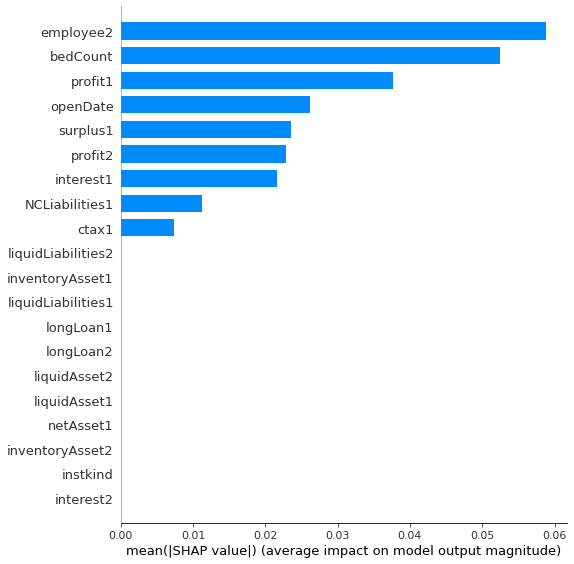

In [15]:

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(train_prod_X)
shap.summary_plot(shap_values, train_prod_X, plot_type="bar")

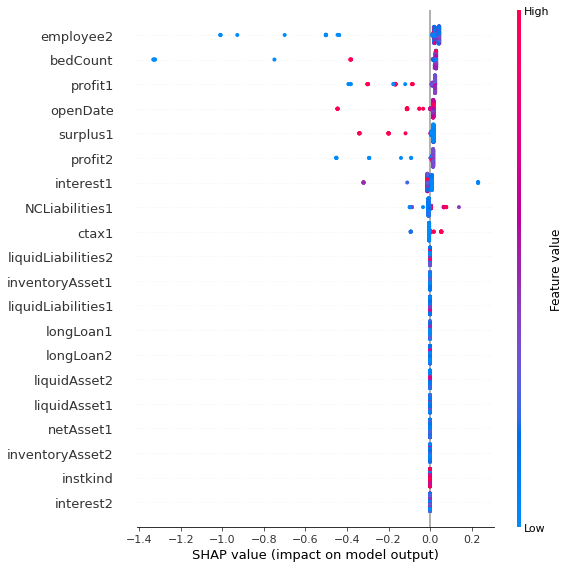

In [17]:
shap.summary_plot(shap_values, train_prod_X)

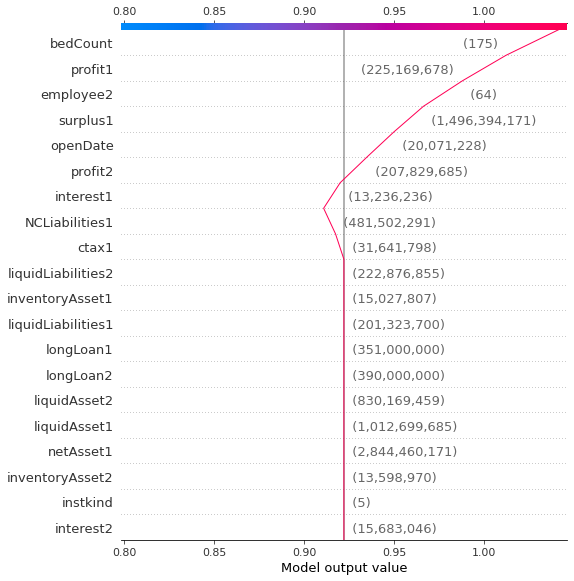

In [18]:
# print the JS visualization code to the notebook
shap.initjs()
shap.decision_plot(explainer.expected_value, shap_values[0,:], train_prod_X.iloc[0,:])

In [19]:
# print the JS visualization code to the notebook
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], train_prod_X.iloc[0,:])

## GBM model 시각화

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


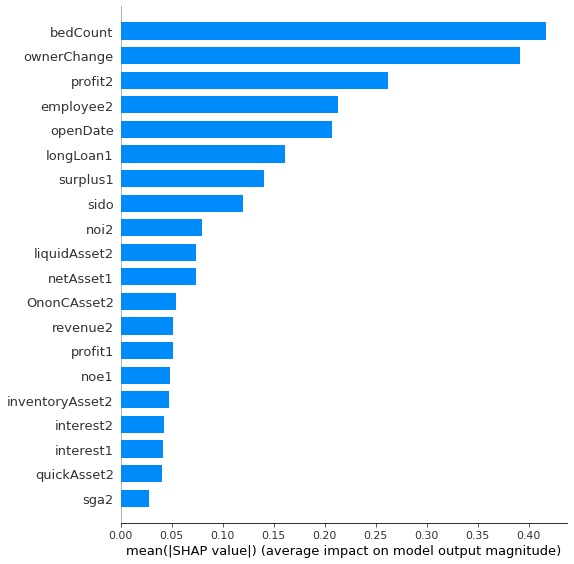

In [20]:

explainer = shap.TreeExplainer(GBM_prod_model)
shap_values = explainer.shap_values(train_prod_X)
shap.summary_plot(shap_values, train_prod_X, plot_type="bar")

## RF model 시각화

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


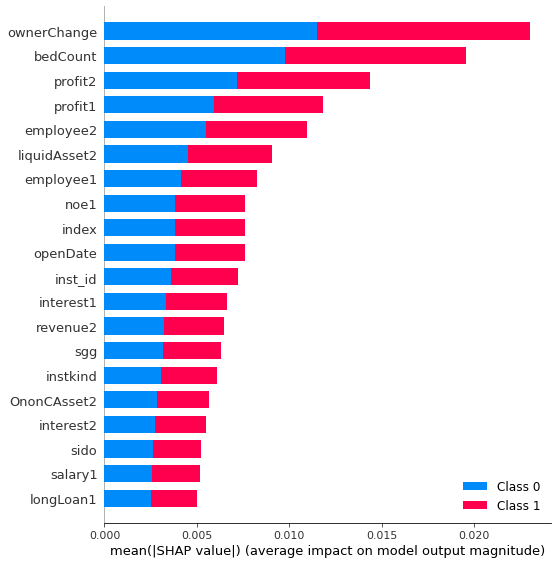

In [21]:
explainer = shap.TreeExplainer(RF_prod_model)
shap_values = explainer.shap_values(train_prod_X)
shap.summary_plot(shap_values, train_prod_X, plot_type="bar")

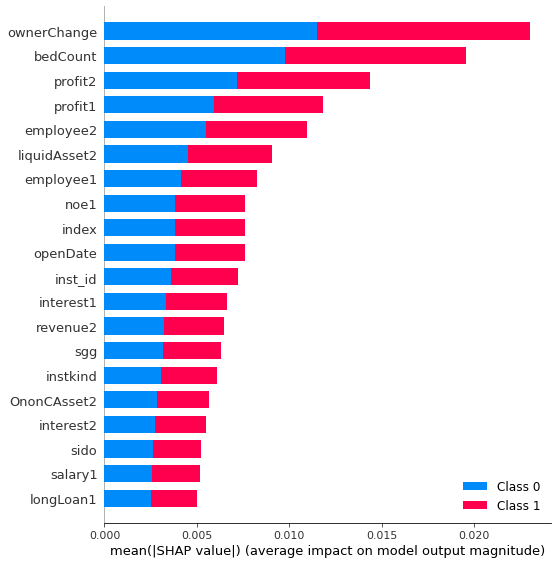

In [22]:
shap.summary_plot(shap_values, train_prod_X)